# Step 1. 인물모드 직접 해 보기

- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

이미지 파일 불러오기 함수

In [2]:
# 이미지 파일 불러오기

def load_image(filename='my_image.png'):
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + filename
    img_orig = cv2.imread(img_path) 
    return img_orig

모델 불러오기

In [31]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
def load_model(file='deeplabv3_xception_tf_dim_ordering_tf_kernels.h5', url='https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'):
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
    # 2
    model_file = os.path.join(model_dir, file) 

    # PixelLib가 제공하는 모델의 url입니다
    model_url = url 

    if not os.path.exists(model_file):
        # 다운로드를 시작합니다
        print('download')
        urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

    model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
    model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
    return model


세그멘테이션 실행

In [4]:
def segment(model, image_name='my_image.png'):
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + image_name
    segvalues, output = model.segmentAsPascalvoc(img_path)
    return segvalues, output

pascalvoc 데이터의 라벨종류

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

라벨에 맞는 seg color 가져오기

In [6]:
def get_seg_color(label='person'):

    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    return colormap[LABEL_NAMES.index(label)][::-1]

In [7]:
get_seg_color()

array([128, 128, 192])

mask 가져오기

In [8]:
def get_mask(output, seg_color):
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    # seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
    seg_map = np.all(output==seg_color, axis=-1) 
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    return img_mask_color

블러 처리

In [9]:
def blur(img, kernel=(13, 13)):
    img_bg = img.copy()
    return cv2.blur(img_bg, kernel)

이미지 합치는 함수

In [10]:
def concat_image(img_orig, img_bg, img_mask_color):
    img_concat = np.where(img_mask_color==255, img_orig, img_bg)
    return img_concat

__백그라운드 blur 처리 통합__

In [35]:
def blur_background(image_file='my_image.png', label='person', kernel=(20,20)):
    img_orig = load_image(image_file)
    img_bg = blur(img_orig, kernel)
    model = load_model()
    seg_values, seg_output = segment(model, image_file)
    seg_color = get_seg_color(label)
    img_mask_color = get_mask(seg_output, seg_color)
    img_concat = concat_image(img_orig, img_bg, img_mask_color)
    
    plt.subplots(1, 2, figsize=(15, 6))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

### 여러 파일에 적용해보기

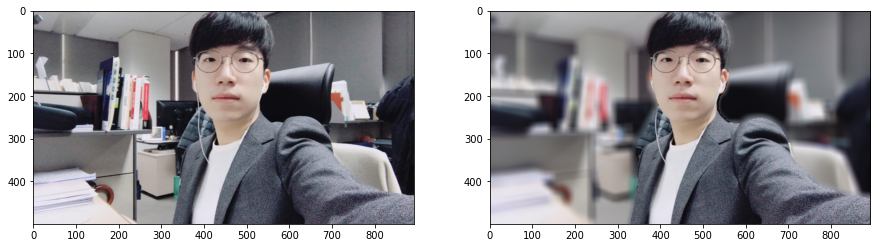

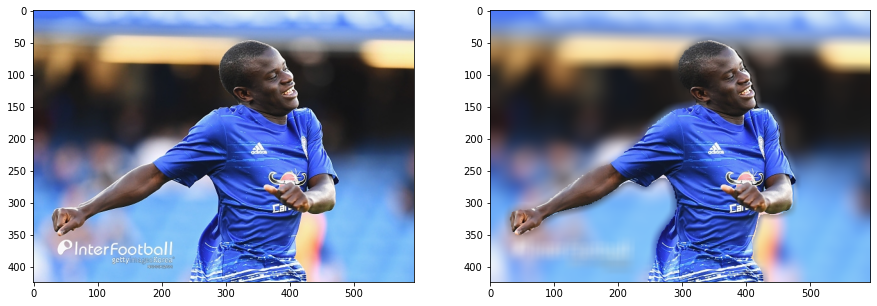

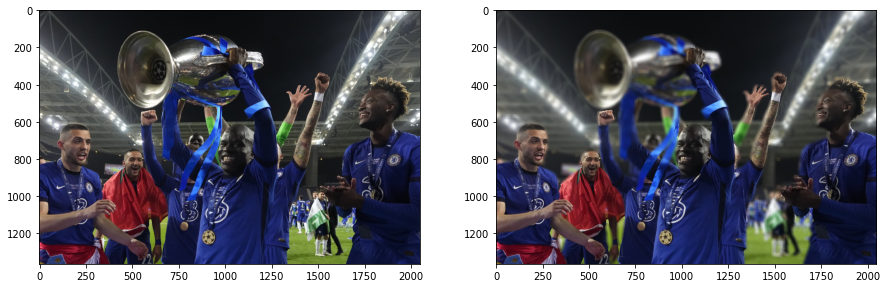

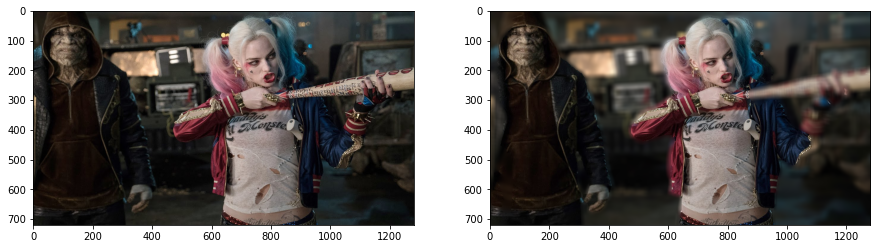

In [36]:
image_files = [
    'my_image.png',
    'kante.jpeg',
    'kante2.jpeg',
    'squad.jpeg',
]
for file in image_files:
    blur_background(file)
    

두번쨰 사진의 경우 블러처리가 되있는지 모르고 가져왔는데 블러처리가 이미 되있었음. 그외에 들고 있는 물체라던가 옷같은것들이 잘 인식이 안되어서 신체 일부를 잃는 현상이 나타나고 있음 ㅠㅠ

### 고양이도 도전

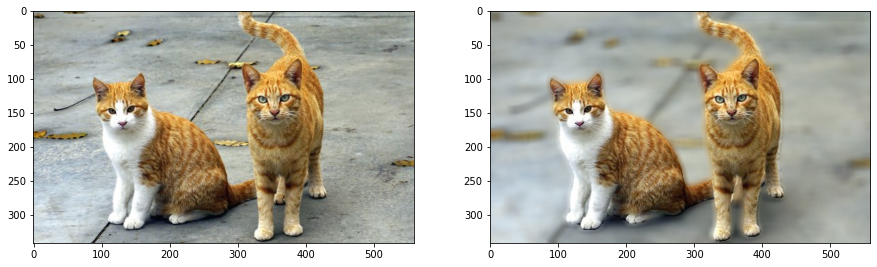

In [32]:
blur_background('cat.jpeg', 'cat', (13,13))

잘 되네용~

### filter size 증가시켜보기

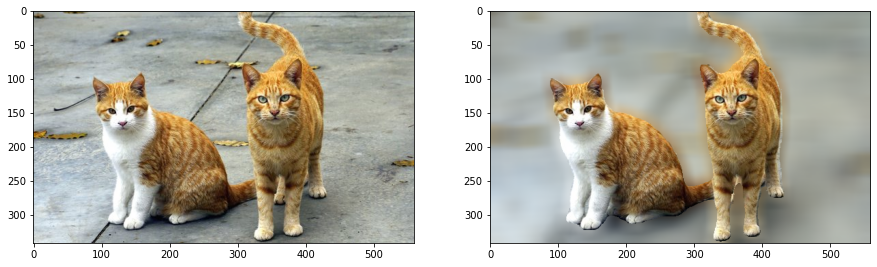

In [34]:
blur_background('cat.jpeg', 'cat', (32,32))

커널이 커지니 배경이 더 흐릿해짐을 확인

### 다른 백그라운드 사진 삽입해보기

In [40]:
def change_background(image_file='my_image.png', background_file='bg.jpeg', label='person'):
    img_orig = load_image(image_file)
    # resize 로직 추가
    height, width = img_orig.shape[:2]
    img_bg = load_image(background_file)
    img_bg = cv2.resize(img_bg, (width, height))
    
    model = load_model()
    seg_values, seg_output = segment(model, image_file)
    seg_color = get_seg_color(label)
    img_mask_color = get_mask(seg_output, seg_color)
    img_concat = concat_image(img_orig, img_bg, img_mask_color)
    
    plt.subplots(1, 2, figsize=(15, 6))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

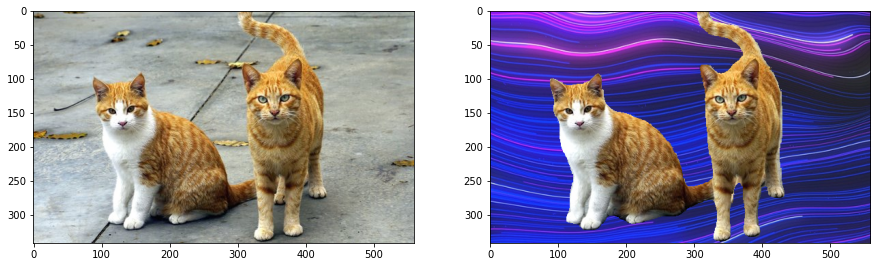

In [42]:
change_background('cat.jpeg', 'bg.jpeg', 'cat')

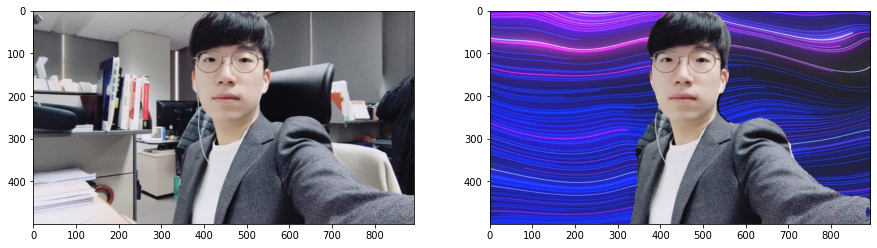

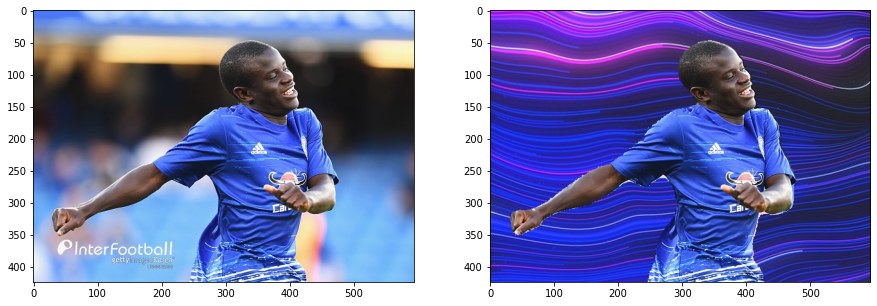

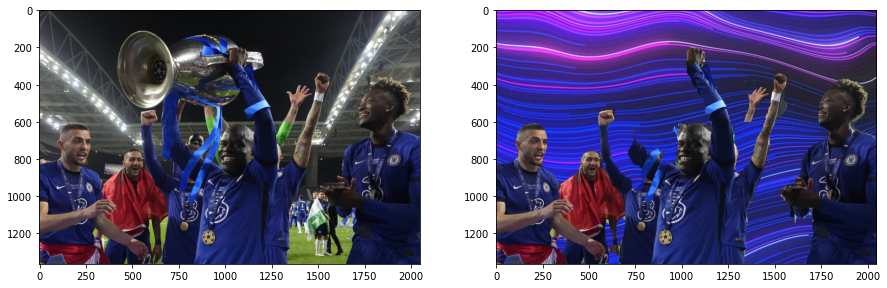

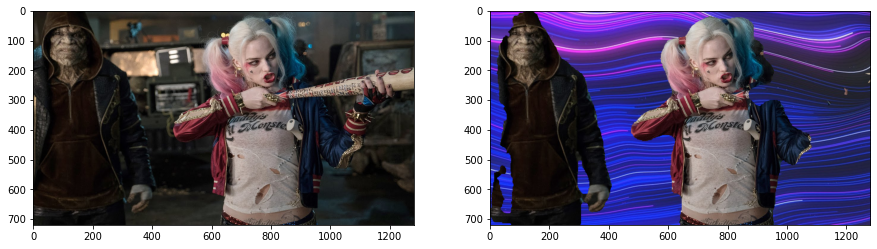

In [43]:
image_files = [
    'my_image.png',
    'kante.jpeg',
    'kante2.jpeg',
    'squad.jpeg',
]
for file in image_files:
    change_background(file)

흐리게 했을떄보다 문제점이 더 잘보인당~~

# Step 2. 사진에서 문제점 찾기

그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

![억까](https://github.com/currybab/first-repository/assets/7679722/3630960c-2824-4d6a-96fc-17efa536485a)

귀 뒤쪽에 남는 부분... 머리 좌상단에서 머리로 인식을 안한것 같은 부분..?

![segmenterror](https://github.com/currybab/first-repository/assets/7679722/96e3aa78-a967-400c-b508-aa78ee401831)

팔이 절단 남. 방망이가 사라짐. 신체 일부 소실....ㅠㅠ

# Step 3. 해결 방법을 제안해 보기

아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 솔루션...?

1. 사전 학습된 모델로 segmentation 진행
2. mask와 사진의 이미지 깊이에 대한 정보를 통해 mask의 경계에 대한 부분에 알고리즘을 추가함.
3. 추가 알고리즘으로 인해 mask의 경계가 더욱 정밀도가 올라가게 되어 위의 문제점이 해결될 수 있음.